In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotTools as pltools

# Featurization

Load the descriptor file, in this case SOAP

In [2]:
DS_DIR = '/home/andreag/Work/2.side_project/1.ionut_litions/test_code/0.SOAP/TEST/'

In [3]:
ds = np.load(DS_DIR+'turbo_rcutH4.5_rcutS3.5_nmax8_lmax0_Nsp8_n_Z1_Z3_0-500-1.npy')
ds.shape

(500, 114, 2080)

This system contains:
-   500 trajectory frames
-   114 different Li atoms featurized as a SOAP environments
-   the SOAP features

The output shape is in the stadard format after the featurization, which is ordered by content of the simulation box at each frame (500).

First thing we need to take care is the cration of a time-series, i.e., an ordered (in time) sequence of the SOAP feature vectors for each of the Li.
We will consider as indipendet each of the different Li, as they will have their own different time-serie.

In [4]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

In [5]:
def build_timeseries(ds: np.ndarray, lag: int=1):
    # check for multiple-particle data
    if len(ds) > 2:
        print(f"Multi particles data - {np.shape(ds)}")
        # redshape the data to match the timeserie requirements
        traj_list = [np.vstack([ts[particle] for ts in ds]) for particle in np.arange(0, ds.shape[1])]
        # create the individual timeseries
        tseries_list = [
            TrajectoryDataset(lagtime=lag, trajectory=traj.astype(np.float64))
            for traj in traj_list
        ]
        timeseries = TrajectoriesDataset(tseries_list)
    
    else:
        print(f"Single particles data - {np.shape(ds)}")
        timeseries = TrajectoryDataset(lagtime=lag, trajectory=ds.astype(np.float64))

    return timeseries

In [6]:
ds_tseries = build_timeseries(ds=ds)

Multi particles data - (500, 114, 2080)


The object returned by the function is going to be the main ingredient of the MSM workflow (using DeepTime)

In [7]:
type(ds_tseries)

deeptime.util.data.TrajectoriesDataset

## Dimensionality reduction

We will reduce the dimensionality of the SOAP fingerprints.
To do that we will use the tICA dimensionality reduction method.

In [8]:
from deeptime.decomposition import TICA

In [9]:
tica_prms_dict = dict(
    lagtime = 24,
    var_cutoff = .95,
)

In [10]:
tica = TICA(**tica_prms_dict)
tica

TICA-126251685177888:[{'dim': None,
                      'epsilon': 1e-06,
                      'lagtime': 24,
                      'observable_transform': <deeptime.basis._monomials.Identity object at 0x72d342eafef0>,
                      'scaling': 'kinetic_map',
                      'var_cutoff': 0.95}]

We did not set a number of output variables, but we have set a treshold on the number of _kinetic variance_ we want to keep while performing the reduction, i.e., we will retain 'dimensions' to account for 95% of the kinetic variance.

In [11]:
dimred_model = tica.fit_from_timeseries(ds_tseries).fetch_model()

after the model has been fit with our data we can project the SOAP timeseries in the tICA reduced space.

In [12]:
X = dimred_model.transform(ds_tseries.trajectories)

In [13]:
X.shape

(114, 500, 7)

In [14]:
print(f"Ncomopnents= {X.shape[2]} (max:{len(dimred_model.cumulative_kinetic_variance)})")


Ncomopnents= 7 (max:22)


/home/andreag/Work/2.side_project/1.ionut_litions/git_repo/MSM-MLanalysis/plotTools.py:81: RuntimeWarning: divide by zero encountered in log
  FES = -1 * KBT * np.log(H)


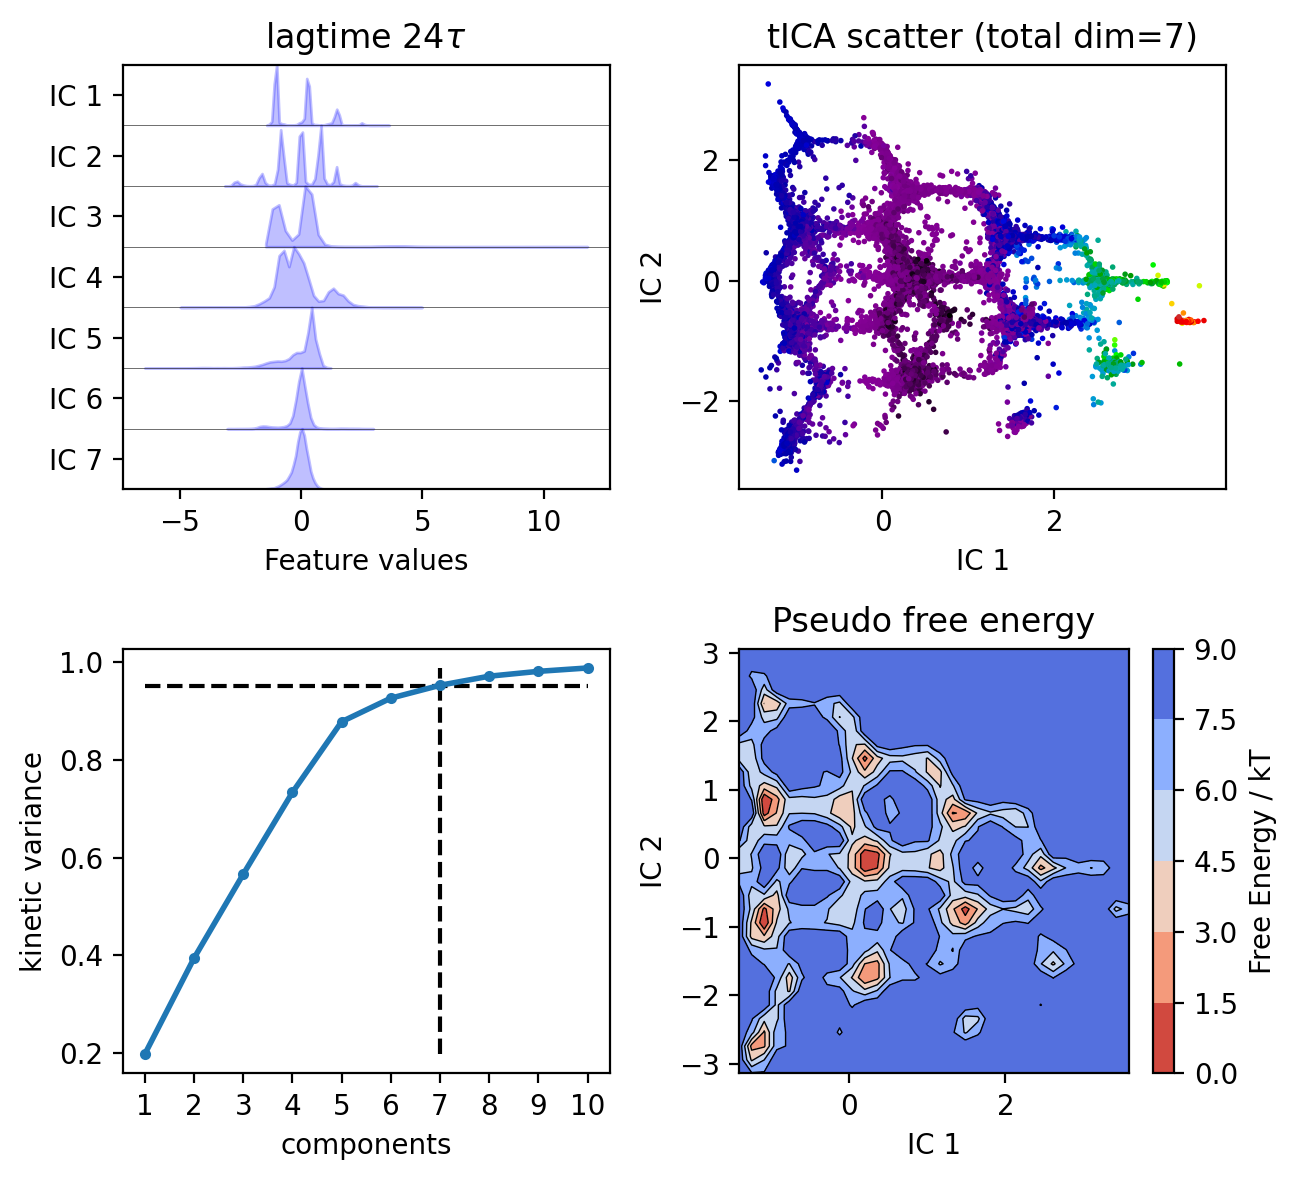

In [15]:
fig, ax = pltools.get_axes(4,2)

kvar = dimred_model.cumulative_kinetic_variance
Xconc = np.concatenate(X)
tica_ic_treshold = Xconc.shape[1]+3

pltools.plot_feature_histograms(Xconc, ax=ax[0],
                                feature_labels=['IC {}'.format(i+1) for i in range(Xconc.shape[1])])
ax[0].set_title(f'lagtime {tica_prms_dict['lagtime']}'+r'$\tau$')

ax[1].scatter(Xconc[:,0], Xconc[:,1], c=Xconc[:,2],
              cmap='nipy_spectral', s=1)
ax[1].set_title(f"tICA scatter (total dim={Xconc.shape[1]})")
ax[1].set_xlabel('IC 1')
ax[1].set_ylabel('IC 2')

ax[2].plot(kvar[:tica_ic_treshold], '.-', lw=2)
ax[2].plot([.95]*(tica_ic_treshold), '--', c='.0', zorder=1)
ax[2].plot([Xconc.shape[1]-1]*(tica_ic_treshold), kvar[:tica_ic_treshold], '--', c='.0', zorder=1)
ax[2].set_xticks(np.arange(tica_ic_treshold), np.arange(1, tica_ic_treshold+1))
ax[2].set_xlabel('components')
ax[2].set_ylabel('kinetic variance')

XX,YY,FES = pltools.setFES2D(Xconc[:,0], Xconc[:,1], 
                             bins=32, kb='unit')
pltools.plotFES2D(XX,YY,FES, 
                  levels=7, figure=fig,
                  axes=ax[3], 
                  colorbar=True, 
                  cbar_label='Free Energy / kT',
                  contlabels=False)
ax[3].set_title('Pseudo free energy')
ax[3].set_xlabel('IC 1')
ax[3].set_ylabel('IC 2')

fig.tight_layout()

# Discretization of the space

This is an essential step in the MSM workflow as it allows us for a first guess on the _time evolution_ markov operator.
The idea is to create enough microstates from out data to have a high accuracy in approximating the operator.

In [16]:
from deeptime.clustering import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

In [17]:
kmeans_input_dict = dict(
    n_clusters = 100,
    fixed_seed = 73,
    max_iter = 5000,
    n_jobs=8,
    progress=tqdm,
)

In [18]:
estimator = KMeans(**kmeans_input_dict)

In [19]:
clustering = estimator.fit(Xconc).fetch_model()

KMeans iterations: 100%|██████████| 62/62 [00:00<00:00, 63.36it/s]  


In [20]:
labels = clustering.transform(Xconc)

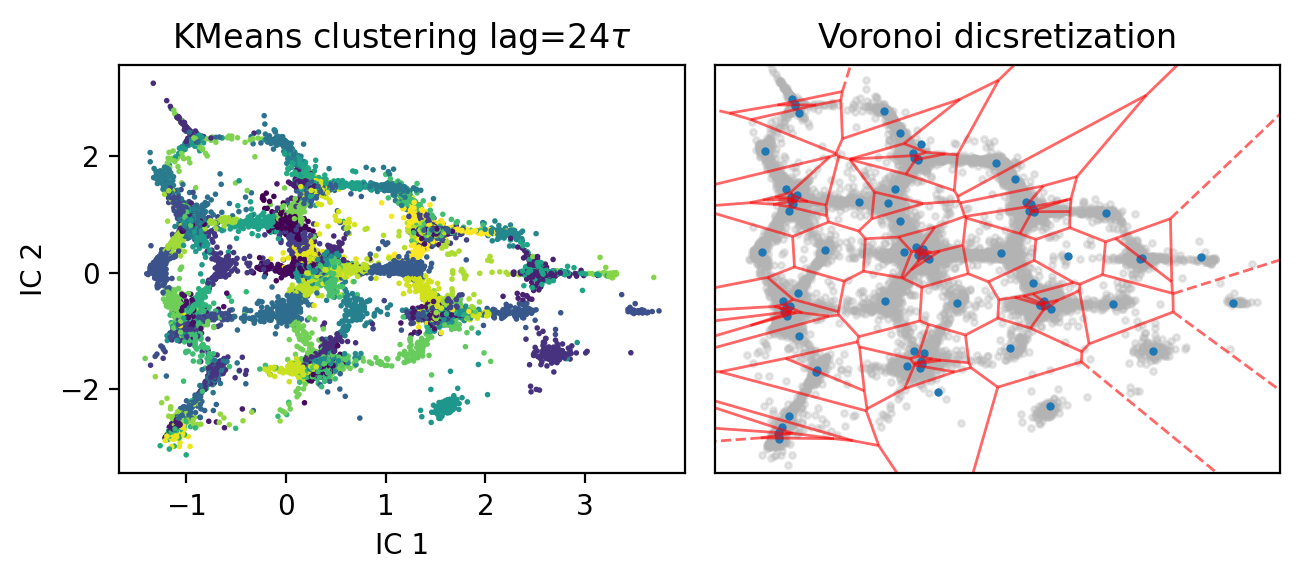

In [21]:
fig, ax = pltools.get_axes(2,2)

ax[0].scatter(Xconc[:,0], Xconc[:,1], s=1, c=labels)
ax[0].set_title(f"KMeans clustering lag={tica_prms_dict['lagtime']}"+r"$\tau$")
ax[0].set_xlabel('IC 1')
ax[0].set_ylabel('IC 2')

vor = Voronoi(clustering.cluster_centers[:,:2])
ax[1].scatter(Xconc[:,0], Xconc[:,1], s=5, alpha=.3, c='.7')
_ = voronoi_plot_2d(vor, show_points=True,
                    show_vertices=False, 
                    line_colors='red',
                    line_width=1, 
                    line_alpha=0.6, 
                    point_size=4,
                    ax=ax[1])
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title(f"Voronoi dicsretization")

fig.tight_layout()

# MSM

In [22]:
import deeptime.markov as markov

In [23]:
n_particles = X.shape[0]

In [24]:
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [25]:
msm = estimator.fit_from_discrete_timeseries(
    discrete_timeseries=labels.reshape(n_particles,-1),
    lagtime=tica_prms_dict['lagtime'], 
    count_mode='sliding').fetch_model()

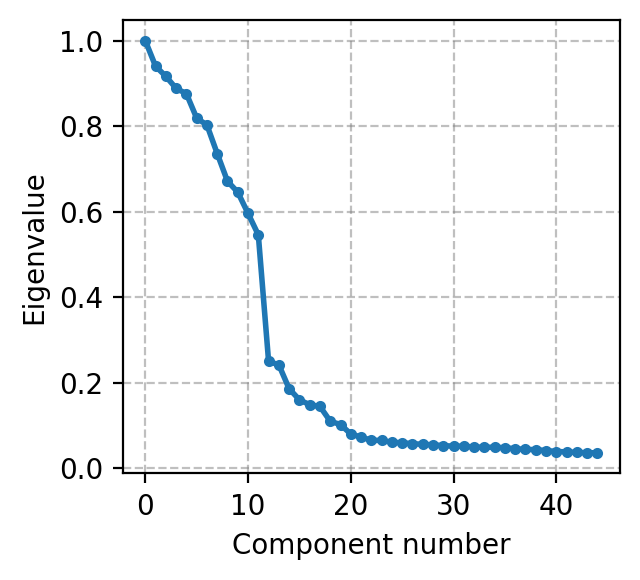

In [26]:
n_eigval = 45

fig, ax = pltools.get_axes(1,1)

ax.plot(np.abs(msm.eigenvalues()[:n_eigval]), '.-', lw=2)
ax.set_xlabel('Component number')
ax.set_ylabel('Eigenvalue')
ax.grid(True,ls='--',c='0.5',alpha=0.5)

fig.tight_layout()

We are going to keep only the first 12 states that corresponds roughly to the 11th slower timescales (the first timescale is the equilibrium distribution of the system).

The goal is to reduce the dimensionality of our approximated matrix from 100x100 to 12x12.
This meas creating a new approximated time evolution operator that contains only the states that are truly markovian for our system.

To do that we will use PCCA++ on the transition matrix.

In [27]:
n_markov_states = 12

In [28]:
pcca = msm.pcca(n_metastable_sets=n_markov_states)

In [29]:
pcca_labels = np.argmax(pcca.memberships[labels], axis=1)

In [30]:
def get_cluster_centers(data: np.ndarray, labels: list[int]) -> dict:
    point_per_cluster_dict = dict()
    for clid in np.unique(labels):
        point_per_cluster_dict[clid] = np.average(
            np.vstack([point for point,label in zip(data, labels) if label==clid]),
            axis=0
            )    
    return point_per_cluster_dict

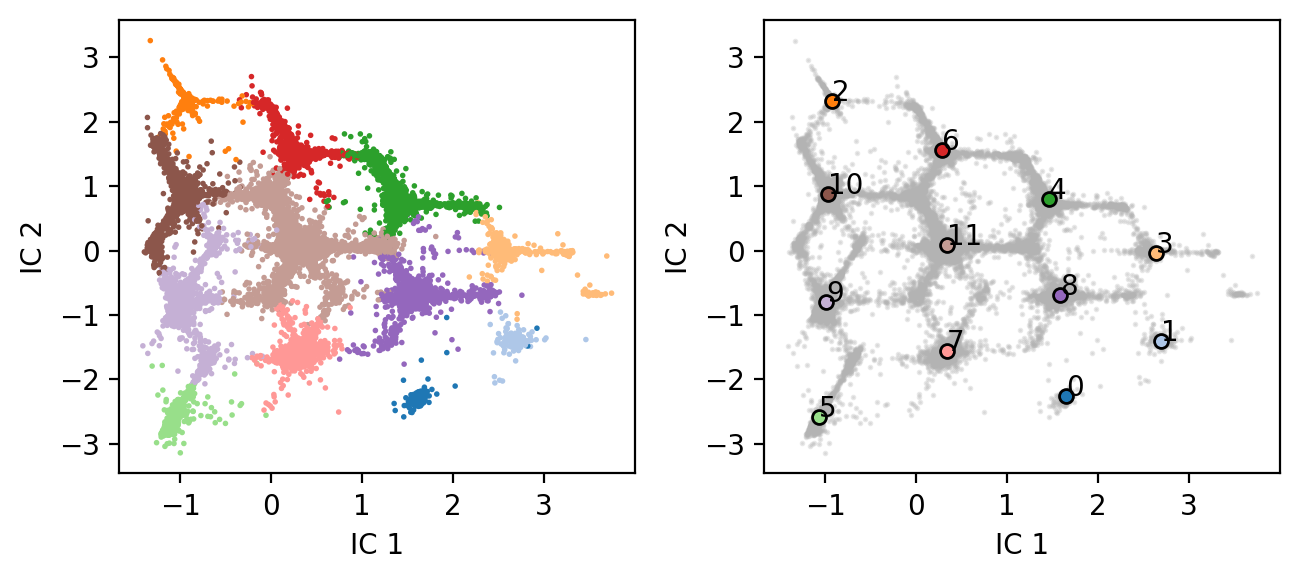

In [31]:
pcca_palette = sns.color_palette('tab20', len(np.unique(pcca_labels)))

pcca_labels_centers = get_cluster_centers(data=Xconc[:,:2], labels=pcca_labels)

fig, ax = pltools.get_axes(2,2)

ax[0].scatter(Xconc[:,0], Xconc[:,1], s=1, c=np.array(pcca_palette)[pcca_labels])

ax[1].scatter(Xconc[:,0], Xconc[:,1],s=1,c='0.7',alpha=.3)
for i,(clid, points) in enumerate(pcca_labels_centers.items()):
    ax[1].scatter(*points.T, label=clid, color=pcca_palette[i],
                  s=25, zorder=2, edgecolors='0')
    ax[1].annotate(clid, (points[0], points[1]))

for i in range(2):
    ax[i].set_xlabel('IC 1')
    ax[i].set_ylabel('IC 2')
fig.tight_layout()

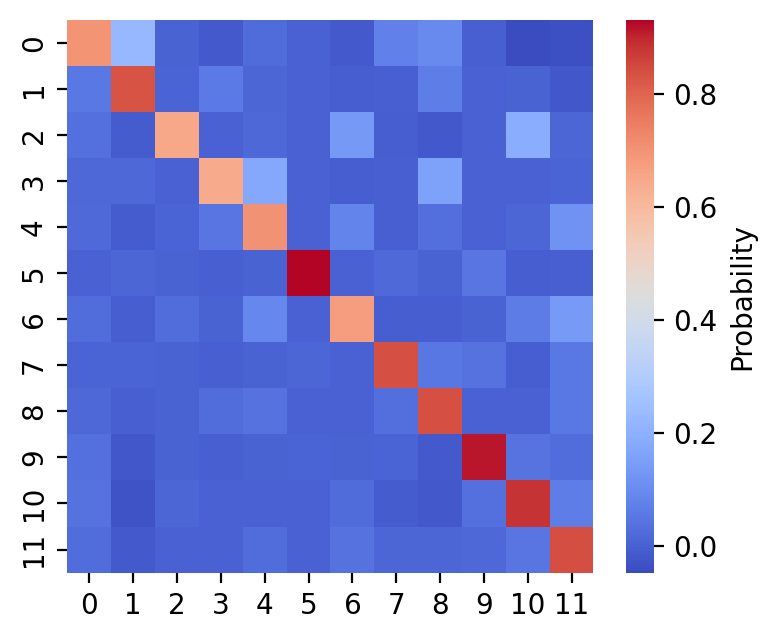

In [32]:
matrix = pcca.coarse_grained_transition_matrix

fig, ax = pltools.get_axes(1,1,fig_frame=(4,3.3))

m = sns.heatmap(matrix, cmap='coolwarm',
                cbar_kws={'label': 'Probability'},
                mask=matrix==0, ax=ax)

fig.tight_layout()

## New MSM

In [33]:
n_centers = X.shape[0]
tau = 24

new_estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

new_msm = new_estimator.fit_from_discrete_timeseries(
    discrete_timeseries=pcca_labels.reshape(n_centers,-1),
    lagtime=tau, count_mode='sliding').fetch_model()

In [34]:
new_msm.lagtime, new_msm.n_states

(24, 12)

In [35]:
eq_distribution = msm.stationary_distribution

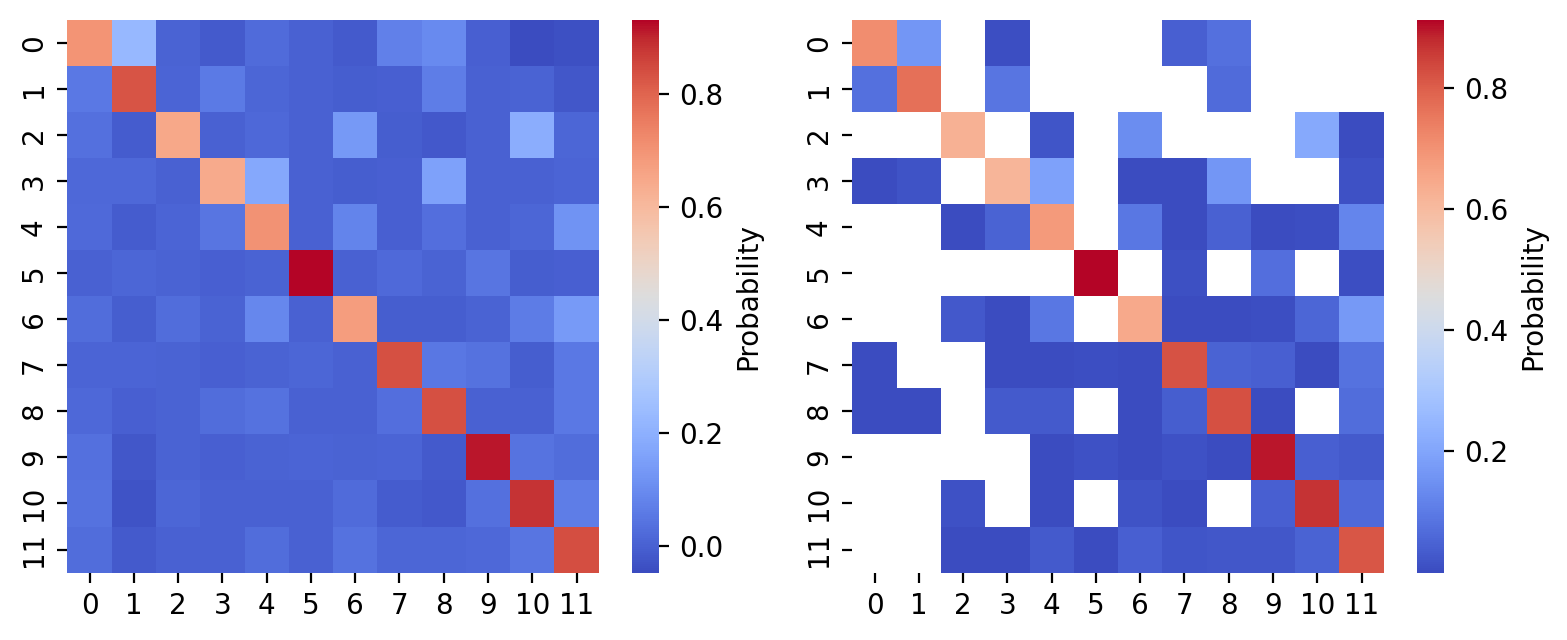

In [36]:
matrix_pcca = pcca.coarse_grained_transition_matrix
matrix_new_msm = new_msm.transition_matrix

fig, ax = pltools.get_axes(2, 2, fig_frame=(4,3.3))

m = sns.heatmap(matrix_pcca, cmap='coolwarm',
                cbar_kws={'label': 'Probability'},
                mask=matrix==0, ax=ax[0])

m1 = sns.heatmap(matrix_new_msm, cmap='coolwarm',
                cbar_kws={'label': 'Probability'},
                mask=matrix_new_msm==0, ax=ax[1])

fig.tight_layout()

/tmp/ipykernel_11932/824725487.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Blues')
/tmp/ipykernel_11932/824725487.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Reds')


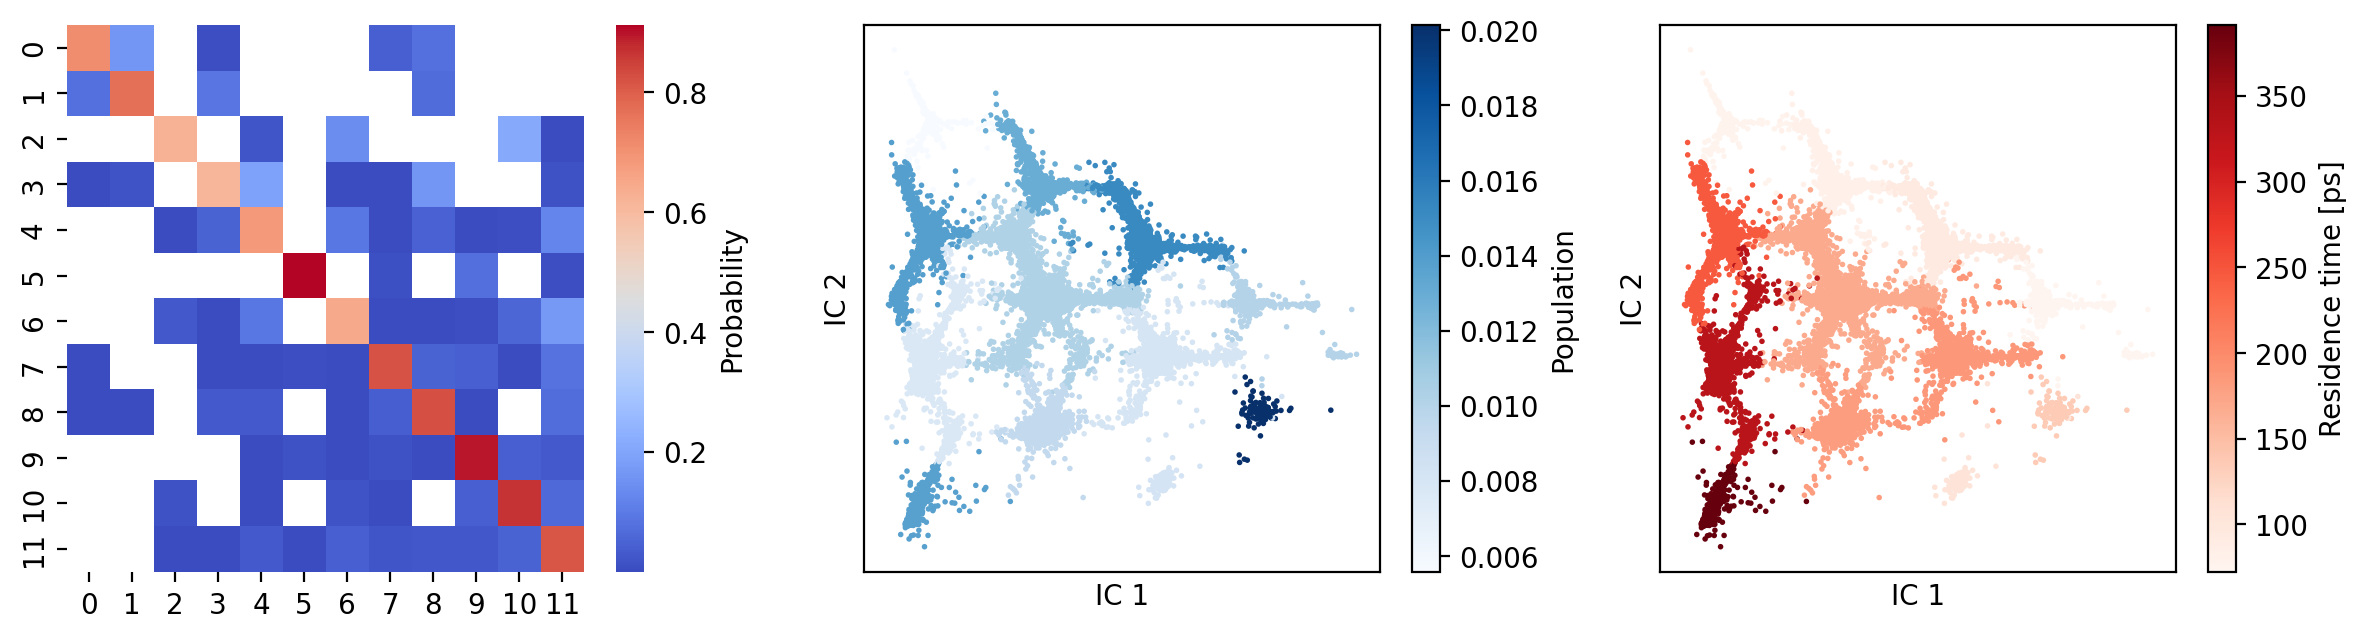

In [37]:
md_tstp = 1.5 #ps

# associate state distribution
statdistr = [eq_distribution[l] for l in pcca_labels]

# estimate rate matrix with lag
ratem = markov.tools.estimation.rate_matrix(
    C=new_msm.count_model.count_matrix_full,
    dt=tau
)
# estimate residence times from it ???
times = -1/ratem.diagonal()*md_tstp
timedistr = [times[l] for l in pcca_labels]

fig, ax = pltools.get_axes(3,3,fig_frame=(4,3.3))

m = sns.heatmap(new_msm.transition_matrix, cmap='coolwarm',
                cbar_kws={'label': 'Probability'},
                mask=new_msm.transition_matrix==0, ax=ax[0])

cm = plt.cm.get_cmap('Blues')
sc = ax[1].scatter(Xconc[:,0], Xconc[:,1],s=1,c=statdistr,cmap=cm)
cbar = fig.colorbar(sc,ax=ax[1])
cbar.set_label('Population')

cm = plt.cm.get_cmap('Reds')
sc = ax[2].scatter(Xconc[:,0], Xconc[:,1],s=1,c=timedistr,cmap=cm)
cbar = fig.colorbar(sc,ax=ax[2])
cbar.set_label('Residence time [ps]')

for i in range(1,3):
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].xaxis.set_ticks_position('none')
    ax[i].yaxis.set_ticks_position('none')
    ax[i].set_xlabel('IC 1')
    ax[i].set_ylabel('IC 2')
    
fig.tight_layout()